<a href="https://colab.research.google.com/github/AndreKaled/classificador-cao-gato/blob/main/classificador_cao_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição inicial
blabla isso classifica caes e gatinhos
# sumario pra acompanhar?
seria bom eu acho


## Instalando dependências

In [1]:
%pip install torch LTNtorch kagglehub pandas torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


## Importando bibliotecas

In [1]:
import pandas as pd
import os
import warnings
import kagglehub
from kagglehub import KaggleDatasetAdapter
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import ltn
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

/home/plaaeo/uni/ia/classificador-cao-gato/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Baixando dataset com imagens de cães e gatos

In [2]:
# Baixa e extrai
dataset_name = "shaunthesheep/microsoft-catsvsdogs-dataset"
dataset_path = kagglehub.dataset_download(dataset_name)

print("Dataset baixado em:", dataset_path)

Dataset baixado em: /home/plaaeo/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


### Explorando estrutura do dataset

In [3]:
print(os.listdir(dataset_path))

['readme[1].txt', 'PetImages', 'MSR-LA - 3467.docx']


In [4]:
main_folder_path = Path(dataset_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != dataset_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
1,2
PetImages,0
Cat,12501
Dog,12501


In [5]:
print(f'Total {count.sum()}')

Total File Count    25004
dtype: int64


In [7]:
# mostra 5 imagens da classe
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

In [8]:
# entra na pasta certa, contendo as pastas com as imagens
print(os.listdir(os.path.join(dataset_path, 'PetImages')))
dataset_path = os.path.join(dataset_path, 'PetImages')

['Cat', 'Dog']


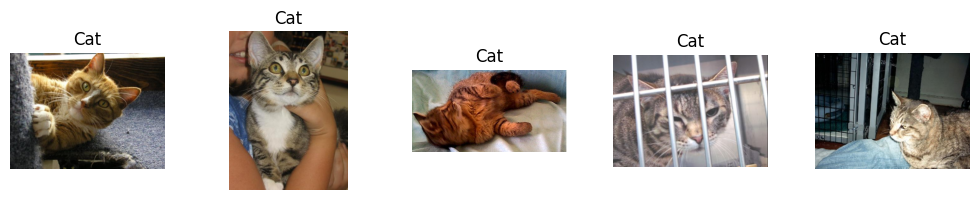

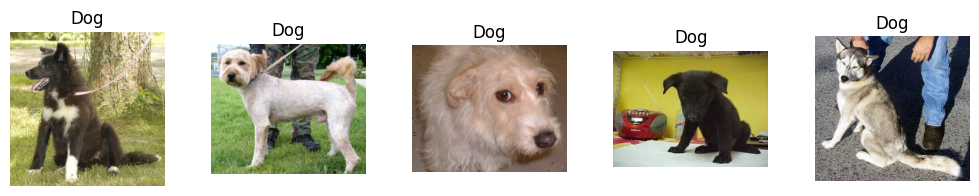

In [9]:
plot_imgs(dataset_path + '/Cat')
plot_imgs(dataset_path + '/Dog')

## Preparando DataLoader pra Pytorch

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # padroniza o tamanho de cada imagem
    transforms.ToTensor()
])

# Ignora arquivos inválidos por classe
def remover_corrompidos(path: str):
    ignore = {
        'Cat': [ '666.jpg' ],
        'Dog': [ '11702.jpg' ],
    }
    
    dir = os.path.basename(os.path.dirname(path))
    return os.path.basename(path) not in ignore[dir] and path.endswith('.jpg')

# dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform, is_valid_file=remover_corrompidos)

# separar dataset em gatos e cães
indices = { c: [ ] for c in dataset.class_to_idx.keys() }
for i, label in enumerate(dataset.targets):
    path, label = dataset.imgs[i]
    indices[dataset.classes[label]].append(i)

dataset_cats = Subset(dataset, indices['Cat'])
dataset_dogs = Subset(dataset, indices['Dog'])

# dividindo em treino e validação
def dividir(dataset):
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

train_cats, val_cats = dividir(dataset_cats)
train_dogs, val_dogs = dividir(dataset_dogs)

# dataloaders
train_cats_loader = DataLoader(train_cats, batch_size=64, shuffle=True, pin_memory=True)
train_dogs_loader = DataLoader(train_dogs, batch_size=64, shuffle=True, pin_memory=True)
val_cats_loader = DataLoader(val_cats, batch_size=64, shuffle=False, pin_memory=True)
val_dogs_loader = DataLoader(val_dogs, batch_size=64, shuffle=False, pin_memory=True)

print("Total de imagens:", len(dataset_cats) + len(dataset_dogs))
print("Treino:", len(train_cats), "gatos,", len(train_dogs), "cães | Validação:", len(val_cats), "gatos,", len(val_dogs), "cães")


Total de imagens: 24998
Treino: 11249 gatos, 11249 cães | Validação: 1250 gatos, 1250 cães


## Preparando CNN


In [11]:
class CNNClassificador(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # camadas convolucionais: detectam padrões na imagem (bordas, texturas, formas)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # reduz resolução pela metade

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # flatten + fully connected: transforma padrões em saidas classificaveis
        self.fc1 = nn.Linear(128*28*28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Sigmoid()

    def forward(self, x):
        # convolução + ReLU + Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # achata para passar pelas fully connected
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # saida final: pontuação para cada classe
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = CNNClassificador(num_classes=2)
print(model)

CNNClassificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Sigmoid()
)


## Preparando treino da CNN

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ltn.device = device
model.to(device)

# função de perda padrão de classificacao binaria
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Lógica LTN

In [14]:
# Define os Agregadores e Otimizador
# Define logical operators
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
# SatAgg (Agregador de Satisfação) calculará a satisfação total da KB
sat_agg = ltn.fuzzy_ops.SatAgg()

In [19]:
model = torch.load('model.pt', weights_only=False)
train_cats.indices = torch.load('train_cats_idx.pt')
train_dogs.indices = torch.load('train_dogs_idx.pt')
val_cats.indices = torch.load('val_cats_idx.pt')
val_dogs.indices = torch.load('val_dogs_idx.pt')

# Verificar se `dataset_imgs` == `dataset.imgs` corretamente
is_different = False
dataset_imgs = torch.load('dataset_idx.pt')
for (real, _), (saved, _) in zip(dataset.imgs, dataset_imgs):
    same_filename = os.path.basename(real) == os.path.basename(saved)
    same_class = os.path.basename(os.path.dirname(real)) == os.path.basename(os.path.dirname(saved))
    is_different = is_different or (not same_filename) or (not same_class)

if is_different:
    raise ValueError("Os índices de treino/teste estão incorretos, pois os arquivos foram lidos em uma ordem diferente (dataset_imgs != dataset.imgs)")

In [ ]:
D = ltn.Predicate(model)

# Loop de Treinamento
for epoch in range(40):
    train_loader = zip(train_cats_loader, train_dogs_loader)
    train_sat = train_loss = 0.
    for batch, (cats, dogs) in enumerate(train_loader):
        cat = cats[0]
        dog = dogs[0]

        optimizer.zero_grad()

        # 1. Defina as variáveis LTN com os dados de treinamento
        x_C = ltn.Variable("x_C", cat)
        x_D = ltn.Variable("x_D", dog)

        # 2. Calcule a satisfação total da Base de Conhecimento
        sat = sat_agg(
            # Axioma 1: Para todo x_D, D(x_D) deve ser verdadeiro
            Forall(x_D, D(x_D)),
    
            # Axioma 2: Para todo x_C, ~D(x_C) deve ser verdadeiro
            Forall(x_C, Not(D(x_C)))
        )
        
        # 3. Calcule a perda (loss)
        loss = 1. - sat

        # 4. Backpropagation e Otimização
        loss.backward()
        optimizer.step()

        train_sat += sat.item()
        train_loss += loss.item()

        if batch % 10 == 0:
            print(f" Batch {batch}: Nível de Satisfação (Sat): {sat.item():.4f}, Perda (Loss): {loss.item():.4f}")

    length = min(len(train_cats_loader), len(train_dogs_loader))
    train_sat /= length
    train_loss /= length
    print(f"Epoch {epoch}: Nível de Satisfação (Sat): {train_sat:.4f}, Perda (Loss): {train_loss:.4f}")
    
print("Treinamento concluído.")

 Batch 0: Nível de Satisfação (Sat): 0.4992, Perda (Loss): 0.5008
 Batch 10: Nível de Satisfação (Sat): 0.5014, Perda (Loss): 0.4986
 Batch 20: Nível de Satisfação (Sat): 0.4961, Perda (Loss): 0.5039
 Batch 30: Nível de Satisfação (Sat): 0.5054, Perda (Loss): 0.4946
 Batch 40: Nível de Satisfação (Sat): 0.5004, Perda (Loss): 0.4996
 Batch 50: Nível de Satisfação (Sat): 0.5114, Perda (Loss): 0.4886
 Batch 60: Nível de Satisfação (Sat): 0.5075, Perda (Loss): 0.4925
 Batch 70: Nível de Satisfação (Sat): 0.5144, Perda (Loss): 0.4856
 Batch 80: Nível de Satisfação (Sat): 0.5137, Perda (Loss): 0.4863
 Batch 90: Nível de Satisfação (Sat): 0.5534, Perda (Loss): 0.4466
 Batch 100: Nível de Satisfação (Sat): 0.5243, Perda (Loss): 0.4757
 Batch 110: Nível de Satisfação (Sat): 0.5366, Perda (Loss): 0.4634
 Batch 120: Nível de Satisfação (Sat): 0.5294, Perda (Loss): 0.4706
 Batch 130: Nível de Satisfação (Sat): 0.5516, Perda (Loss): 0.4484
 Batch 140: Nível de Satisfação (Sat): 0.5226, Perda (Loss)

In [16]:
torch.save(model, 'model.pt')
torch.save(dataset.imgs, 'dataset_idx.pt')
torch.save(train_cats.indices, 'train_cats_idx.pt')
torch.save(train_dogs.indices, 'train_dogs_idx.pt')
torch.save(val_cats.indices, 'val_cats_idx.pt')
torch.save(val_dogs.indices, 'val_dogs_idx.pt')

Text(0.5, 1.0, 'Dog(...) = 0.0000')

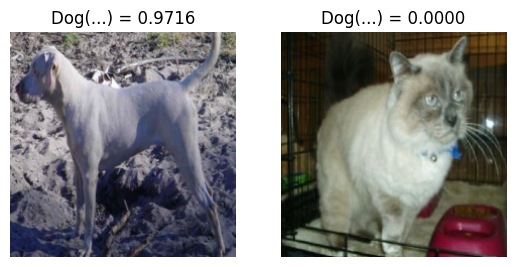

In [28]:
from torchvision.transforms import ToPILImage
from random import randint
model.eval()

if 'val_dogs_iter' not in globals() or 'val_cats_iter' not in globals():
    val_dogs_iter = iter(val_dogs_loader)
    val_cats_iter = iter(val_cats_loader)

dogs = next(val_dogs_iter)
cats = next(val_cats_iter)

i = randint(0, len(dogs))

dog = dogs[0][i:i+1]
cat = cats[0][i:i+1]

dog_score = D(ltn.Variable("dog", dog)).value[0]
cat_score = D(ltn.Variable("cat", cat)).value[0]

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(ToPILImage()(dog[0].cpu()))
plt.title(f"Dog(...) = {dog_score:.4f}")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(ToPILImage()(cat[0].cpu()))
plt.title(f"Dog(...) = {cat_score:.4f}")


In [29]:
if 'dogs' in globals(): del dogs
if 'cats' in globals(): del cats
if 'x_C' in globals(): del x_C
if 'x_D' in globals(): del x_D
if 'train_loader' in globals(): del train_loader
if 'axiom_D' in globals(): del axiom_D
if 'axiom_ND' in globals(): del axiom_ND
if 'loss' in globals(): del loss
if 'sat' in globals(): del sat

optimizer.zero_grad()
torch.cuda.empty_cache()

In [20]:
model.eval()

with torch.no_grad():
  val_loader = zip(val_cats_loader, val_dogs_loader)

  val_sat = val_loss = 0.
  correct = total = 0.
  for batch, (cats, dogs) in enumerate(val_loader):
    cat = cats[0][:]
    dog = dogs[0][:]

    # 1. Defina as variáveis LTN com os dados de treinamento
    x_C = ltn.Variable("x_C", cat)
    x_D = ltn.Variable("x_D", dog)

    pred_cats = D(x_C)
    pred_dogs = D(x_D)
    
    correct_dogs = (pred_dogs.value >= 0.5).sum()
    total_dogs = len(pred_dogs.value)
    correct_cats = (pred_cats.value < 0.5).sum()
    total_cats = len(pred_cats.value)

    correct += correct_dogs + correct_cats
    total += total_dogs + total_cats
    print(correct_dogs, total_dogs, " / ", correct_cats, total_cats)
  print(f"Acurácia: {correct/total:.4f}")

NameError: name 'D' is not defined